# Clasificación de valoraciones de Google Play

## Librerias

In [23]:
import pandas as pd
import tensorflow as tf
import re
import nltk
import numpy
import tensorflow.keras
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords

nltk.download('stopwords')

tf.__version__

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'2.1.0'

## Pre procesado de datos

### Importación de dataset

In [2]:
df = pd.read_csv('./dataset/original.csv')

Revisamos si se cargo correctamente

In [3]:
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [4]:
df.tail()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
64290,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64291,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64292,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64293,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64294,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN


In [5]:
df.shape

(64295, 5)

### Depuración de los datos

Se eliminan los datos que que contengan NaN.

In [6]:
df = df.dropna()
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [7]:
df.tail()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
64222,Housing-Real Estate & Property,Most ads older many agents ..not much owner po...,Positive,0.173333,0.486667
64223,Housing-Real Estate & Property,"If photos posted portal load, fit purpose. I'm...",Positive,0.225000,0.447222
64226,Housing-Real Estate & Property,"Dumb app, I wanted post property rent give opt...",Negative,-0.287500,0.250000
64227,Housing-Real Estate & Property,I property business got link SMS happy perform...,Positive,0.800000,1.000000
64230,Housing-Real Estate & Property,"Useless app, I searched flats kondapur, Hydera...",Negative,-0.316667,0.400000


Antes de proceder al procesamiento de los datos, realizamos una exploración previa de las frecuencias de los sentimientos mediante un diagrama de barras

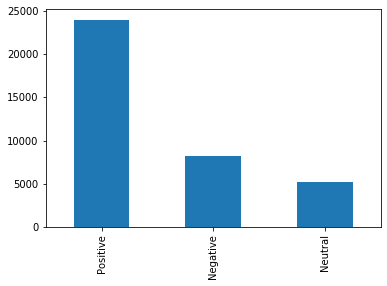

In [8]:
df['Sentiment'].value_counts().plot(kind = 'bar')

Lo que necesitamos analizar es a partir del mensaje determinar si el sentimiento del texto. Para ello aislamos las columnas que necesitamos.

In [9]:
df = df[['Translated_Review', 'Sentiment']]
df.head()

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
3,Works great especially going grocery store,Positive
4,Best idea us,Positive
5,Best way,Positive


A partir de las columnas que nos interesan, se deben realizar los siguientes pasos para poder unificar todas las frases:
- Poner todas las letras en minúscula.
- Eliminar signos de puntuación, convirtiendo todas las palabras que se encontraban juntas en palabras por separado.
- Eliminar las *stop words*: Palabras cortas que carecen de significado por sí mismas, como las conjunciones o preposiciones.

Definimos una función que se encargará de esto, dada la frase `sen` por entrada:

In [10]:
def preprocess_text(sen):
    # Eliminar símbolos de puntuación y números
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Eliminar carácteres sueltos
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Eliminar espacios excesivos
    sentence = re.sub(r'\s+', ' ', sentence)

    # Convertir a minúscula
    sentence = sentence.lower()
  
    # Eliminar las stopwords.
    words = sentence.split()
    filtered_words = [word for word in words if word not in stopwords.words('english')]
    
    return ' '.join(filtered_words)

En la función anterior se está haciendo referencia a la librería `re`, que viene cargada por defecto en Python. Es una librería dedicada para el tratamiento de expresiones regulares. Por consiguiente, tendremos que aplicar la función anterior a cada elemento de la columna `Translated_Review` del dataframe.

In [11]:
df['Translated_Review'] = df['Translated_Review'].apply(lambda sen: preprocess_text(sen))
df.head()

,Translated_Review,Sentiment
0,like eat delicious food cooking food case best...,Positive
1,help eating healthy exercise regular basis,Positive
3,works great especially going grocery store,Positive
4,best idea us,Positive
5,best way,Positive


## Representación vectorial del texto

En esta sección se tendrá por objetivo convertir una cadena de texto en un vector, para que pueda ser tratado por la red neuronal. En primer lugar, para poder generar los conjuntos de entrenamiento y validación, separaremos el dataframe en dos variables independientes para poder tratarlas por separado.

In [12]:
def determine_class(label):
  if label == 'Positive':
    return 0
  elif label == 'Neutral':
    return 1
  elif label == 'Negative':
    return 2

# Poner la variable a True si se quieren eliminar los comentarios neutrales.
# En caso contrario, los neutrales se convertirán a negativos
REMOVE_NEUTRAL = False

# Poner la variable a True (siempre que la anterior sea False) para considerar
# las clases 'Negative' y 'Neutral' iguales.
MERGE_NEGATIVE_NEUTRAL = False

if REMOVE_NEUTRAL:
  indexNames = df[df['Sentiment'] == 'Neutral'].index
  df.drop(indexNames , inplace=True)

  y = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0).to_numpy()
  #y = tf.one_hot(y, 2)
else:
  if MERGE_NEGATIVE_NEUTRAL:
    y = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0).to_numpy()
    #y = tf.one_hot(y, 2)
  else: 
    y = df['Sentiment'].apply(lambda x: determine_class(x)).to_numpy()
    #y = tf.one_hot(y, 3)

X = df['Translated_Review']
y = y.astype(numpy.uint8)

[]

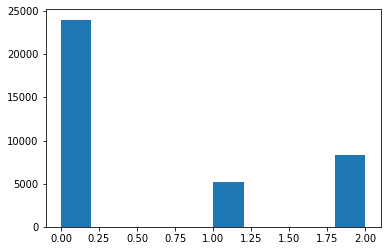

In [13]:
plt.hist(y)
plt.plot()

A partir de la librería `sklearn` podemos separar en dos conjuntos disjuntos, conteniendo el 80% de las muestras para el conjunto de entrenamiento y lo restantepara el de validación.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

El siguiente paso es determinar el número máximo de palabras que se usarán (es decir, las $n$ primeras palabras más frecuentes) y la longitud máxima de cada vector.

In [15]:
NUMBER_OF_WORDS = 20000
MAX_LEN = 100

tokenizer = Tokenizer(num_words = NUMBER_OF_WORDS)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Después, para aquellas frases que tengan palabras que no sean de las más frecuentes, se realiza la técnica de padding rellenando con ceros aquellas palabras que no sean tan frecuentes y no aparecen.

In [18]:
X_train = pad_sequences(X_train, padding='post', maxlen=MAX_LEN)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_LEN)

## Generar el modelo de Red Neuronal Recurrente

In [22]:
VOCABULARY_SIZE = NUMBER_OF_WORDS
EMBEDDING_SIZE = 128

### Creacion de modelo

In [50]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(VOCABULARY_SIZE, EMBEDDING_SIZE, input_shape=(X_train.shape[1],)))

model.add(tf.keras.layers.LSTM(units=128, activation='tanh'))

#En units, se debe especificar cuantas clases tenemos. 
model.add(tf.keras.layers.Dense(units=numpy.unique(y_train).shape[0], activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

### Resumen del modelo

In [51]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 128)          2560000   
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 387       
Total params: 2,691,971
Trainable params: 2,691,971
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento

In [52]:
model.fit(X_train, y_train, epochs=3, batch_size=128)

Train on 29941 samples
Epoch 1/3
29941/29941 [==============================] - 6s 185us/sample - loss: 0.8957 - sparse_categorical_accuracy: 0.6417
Epoch 2/3
29941/29941 [==============================] - 5s 157us/sample - loss: 0.8922 - sparse_categorical_accuracy: 0.6417
Epoch 3/3
29941/29941 [==============================] - 5s 156us/sample - loss: 0.8919 - sparse_categorical_accuracy: 0.6417


### Test

In [53]:
test_loss, test_acurracy = model.evaluate(X_test, y_test)
print("Test accuracy: {}".format(test_acurracy))

7486/7486 [==============================] - 1s 136us/sample - loss: 0.8959 - sparse_categorical_accuracy: 0.6391
Test accuracy: 0.6390596032142639
